In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
# load mat data
from scipy.io import loadmat
from scipy import signal
data = loadmat("./data/high_rise_building_wind.mat")
wind_data = data["windsp_1h"].flatten()
fs = 1
decimation_factor = int(100 / fs)
wind_data = signal.decimate(wind_data, decimation_factor, ftype='fir',)

from scipy.signal import medfilt
wind_data = medfilt(wind_data, kernel_size=3) 
wind_data.shape

(3600,)

In [4]:
frequencies, psd = signal.welch(wind_data-np.mean(wind_data), fs=fs,
                                window='hamming', 
                                scaling='density', nperseg=1024)
frequencies = frequencies[1:]  # 去掉直流分量
psd = psd[1:]
u_bar = np.mean(wind_data)
u10 = u_bar * (10 / 450) ** 0.30
z = 632
z0 = 1.0
H_ = 200
K = 0.4
zd = H_ - z0 / K
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

In [5]:
u10

np.float64(5.892879812080642)

In [6]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type="kaimal-nd")
T = int(wind_data.shape[0]/fs)
w_up = fs/2
N = int(T * w_up)
alpha_0 = 0.30
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=T,
    N=N,
    U_d=u10,
    alpha_0=alpha_0,
    w_up=w_up,
)

n = 100
Z = 632
position = np.zeros((n, 3))
position[:, 2] = np.linspace(232, Z, n)
position[:, 0] = 0
position[:, 1] = 0
wind_speeds = u10 * (jnp.minimum(position[:, 2], 450) / 10) ** alpha_0
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[-1], fs=fs, window='hamming', 
                                   scaling='density', nperseg=1024)

In [7]:
simulator.params

{'K': 0.4,
 'H_bar': 200,
 'z_0': 1.0,
 'alpha_0': 0.3,
 'C_x': 16.0,
 'C_y': 6.0,
 'C_z': 10.0,
 'w_up': 0.5,
 'N': 1800,
 'U_d': np.float64(5.892879812080642),
 'M': 3600,
 'T': 3600.0,
 'dt': 1.0,
 'dw': 0.0002777777777777778,
 'z_d': 197.5,
 'backend': 'numpy'}

[Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (m$^2$/s)')]

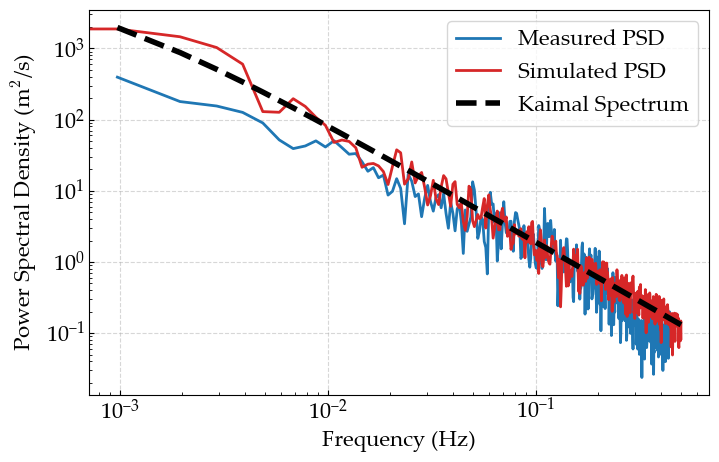

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies[:-60], psd[:-60], label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
# fig.savefig("./img/high_rise_building_wind_spectrum.pdf", bbox_inches="tight")
# fig.savefig("./img/high_rise_building_wind_spectrum.png", bbox_inches="tight", dpi=300)

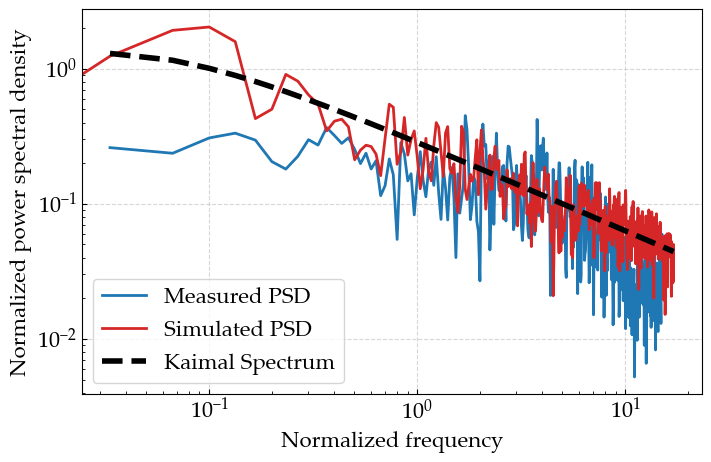

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies[:-60]*z/u_bar, psd[:-60]*frequencies[:-60]/u_star**2, label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim*z/u_bar, psd_sim*frequencies_sim/u_star**2, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies*z/u_bar, reference_psd*frequencies/u_star**2, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Normalized frequency",
         ylabel="Normalized power spectral density")
fig.savefig("./img/high_rise_building_wind_spectrum_norm.pdf", bbox_inches="tight")
fig.savefig("./img/high_rise_building_wind_spectrum_norm.png", bbox_inches="tight", dpi=300)

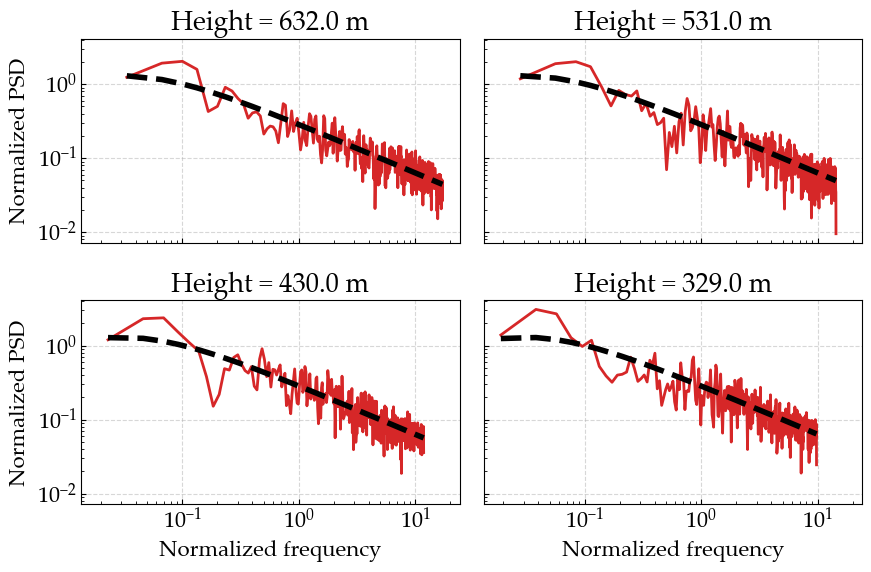

In [62]:
indices = np.arange(100, 0, -25)-1

fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharex=True, sharey=True)
axes = axes.flatten()
for i, idx in enumerate(indices):
    ax = axes[i]
    z = position[idx, 2]
    sample = samples[idx]
    freq, psd = signal.welch(sample, fs=fs, window='hamming', 
                            scaling='density', nperseg=1024)
    freq = freq[1:]
    psd = psd[1:]
    u_bar_z = u10 * (np.minimum(z, 450) / 10) ** alpha_0
    u_star_z = K * u_bar_z / np.log((z - zd) / z0)
    f = freq * z / u_bar_z
    reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star_z**2 / freq
    ax.loglog(freq*z/u_bar_z, psd*freq/u_star_z**2, color="C3", linestyle="solid", lw=2)
    ax.loglog(freq*z/u_bar_z, reference_psd*freq/u_star_z**2, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
    # ax.legend()
    ax.set_title(f"Height = {z:.1f} m")
    if i in [2, 3]:
        ax.set(xlabel="Normalized frequency")
    if i in [0, 2]:
        ax.set(ylabel="Normalized PSD")

fig.tight_layout()